In [5]:
from models import *
from utils import set_seed
from data.loaders import *
from utils import *

In [6]:
user = 'ajimenez'
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/latest-run/files/hsj69u4t_weights_trained/epoch_200"

In [7]:
config = configure_model('config.json', False)

In [8]:
set_seed(0)
device = torch.device('cuda:2')
cose = CoSEModel(config, False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [9]:
#optimizer_ae, optimizer_pos_pred, optimizer_emb_pred 
optimizers = cose.init_optimizers()


train_loader = get_batch_iterator(cose.config.train_dataset_path)

log_dir = f'/home/ajimenez/pruebas'

In [10]:
mean_channel, std_channel = get_stats(cose.config.stats_path)

In [11]:
for batch_input, batch_target in iter(train_loader):
    break

In [12]:
enc_inputs, t_inputs, stroke_len_inputs, inputs_start_coord, inputs_end_coord, num_strokes_x_diagram_tensor = parse_inputs(batch_input,cose.device)
t_target_ink = parse_targets(batch_target,cose.device)

In [13]:
comb_mask , look_ahead_mask, _ = generate_3d_mask(enc_inputs, stroke_len_inputs, cose.device, cose.config.enc_nhead)
encoder_out = cose.encoder(enc_inputs.permute(1,0,2), stroke_len_inputs, comb_mask)
encoder_out_reshaped = encoder_out.unsqueeze(dim=1).repeat(1,t_inputs.shape[1],1).reshape(-1, encoder_out.shape[-1])
t_inputs_reshaped = t_inputs.reshape(-1,1)
decoder_inp = torch.cat([encoder_out_reshaped, t_inputs_reshaped], dim = 1)
strokes_out, ae_mu, ae_sigma, ae_pi= cose.decoder(decoder_inp)

In [14]:
sampled_input_start_pos, sampled_input_emb,sampled_seq_len_emb,sampled_target_start_pos,sampled_target_emb = random_index_sampling(encoder_out = encoder_out, inputs_start_coord = inputs_start_coord,
                                                                                                                                inputs_end_coord = inputs_end_coord, num_strokes_x_diagram_tensor = num_strokes_x_diagram_tensor,
                                                                                                                                input_type =cose.config.input_type, num_predictive_inputs = 32,
                                                                                                                                replace_padding = True, end_positions = False, device = cose.device)

# Base

In [57]:
n_diagram = 900

In [58]:
emb_ = sampled_input_emb[n_diagram][:sampled_seq_len_emb[0].int()].to(cose.device)
base_batch_start_pos = sampled_input_start_pos[n_diagram][:sampled_seq_len_emb[0].int()].to(cose.device)
base_draw_seq_len = np.array([50]*(emb_.size(0)))
base_batch_stroke = decode_sequence(cose.decoder, emb_, base_draw_seq_len, cose.device)

## Prediction

In [59]:
emb_ = sampled_target_emb[n_diagram].unsqueeze(dim=0).to(cose.device)
predicted_batch_start_pos = sampled_target_start_pos[n_diagram].unsqueeze(dim=0).to(cose.device)
predicted_draw_seq_len = np.array([50]*(emb_.size(0)))
predicted_batch_stroke = decode_sequence(cose.decoder, emb_, predicted_draw_seq_len, cose.device)

In [60]:
batch_start_pos = torch.vstack([base_batch_start_pos,predicted_batch_start_pos])
batch_stroke = torch.vstack([base_batch_stroke,predicted_batch_stroke])
draw_seq_len = np.append(base_draw_seq_len, predicted_draw_seq_len)

In [61]:
npfig, fig, _, _ = transform_strokes_to_image(base_batch_stroke.detach().cpu(), base_draw_seq_len, base_batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=base_batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

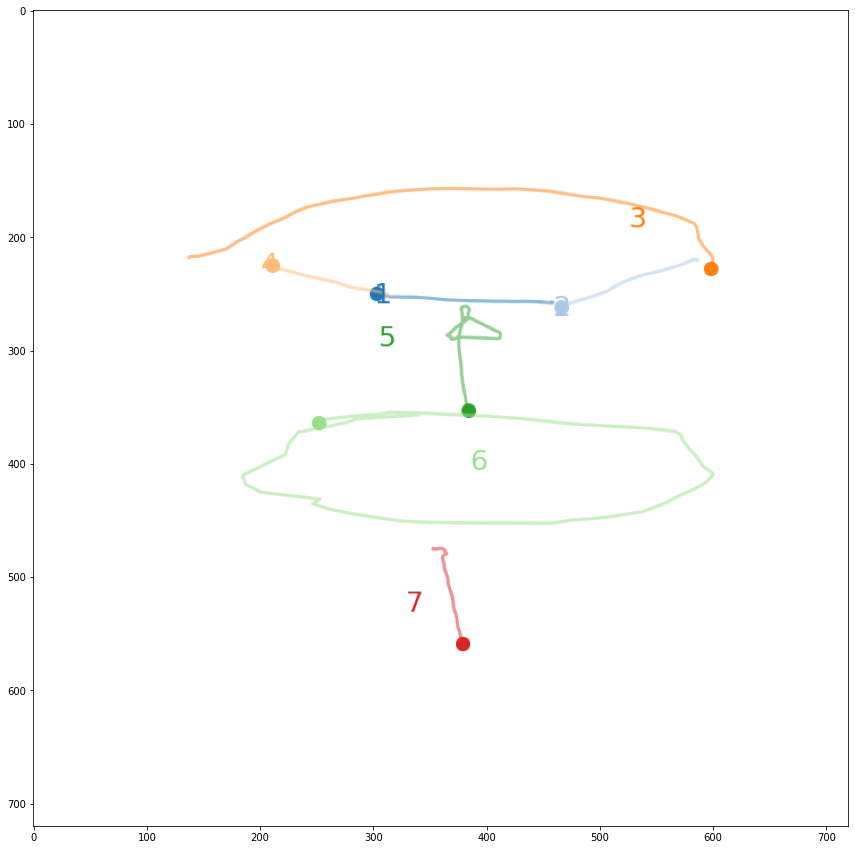

In [62]:
plt.figure(figsize = (15,15))
plt.imshow(npfig)

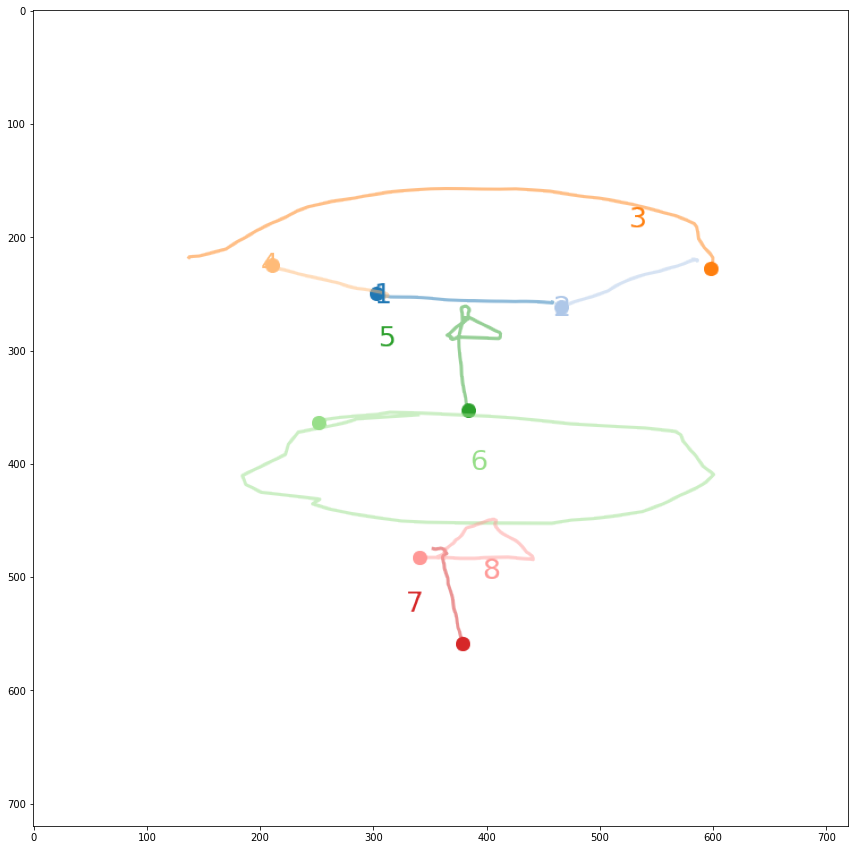

In [63]:
npfig, fig, _, _ = transform_strokes_to_image(batch_stroke.detach().cpu(), draw_seq_len, batch_start_pos.detach().cpu(), mean_channel,
                               std_channel, num_strokes=batch_stroke.shape[0], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)
plt.figure(figsize = (15,15))
plt.imshow(npfig)

In [29]:
emb_.shape

torch.Size([7, 8])

In [17]:
sampled_target_emb.shape

torch.Size([1024, 8])

In [16]:
sampled_target_start_pos.shape

torch.Size([1024, 2])

In [18]:
sampled_seq_len_emb

tensor([7., 7., 7.,  ..., 5., 5., 5.])

In [13]:
sampled_input_start_pos.shape

torch.Size([1024, 7, 2])

In [14]:
sampled_input_emb.shape

torch.Size([1024, 7, 8])